In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/archive/data/training'

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Посмотрим, как выглядит батч

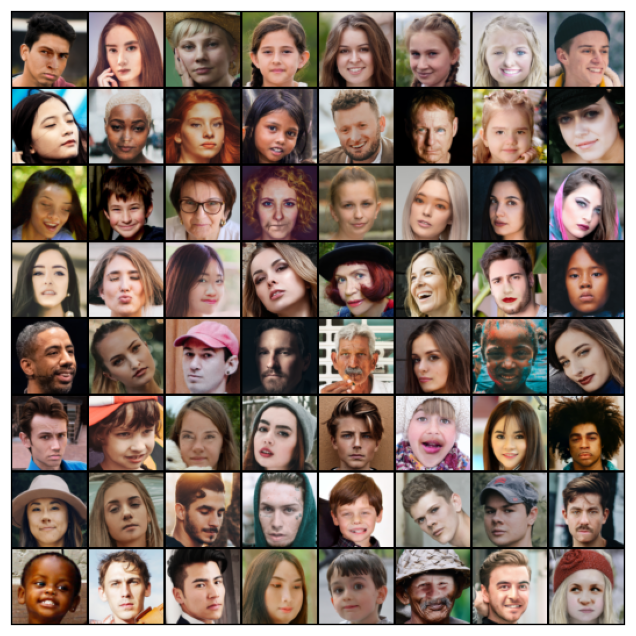

In [ ]:
show_batch(train_dl)

In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


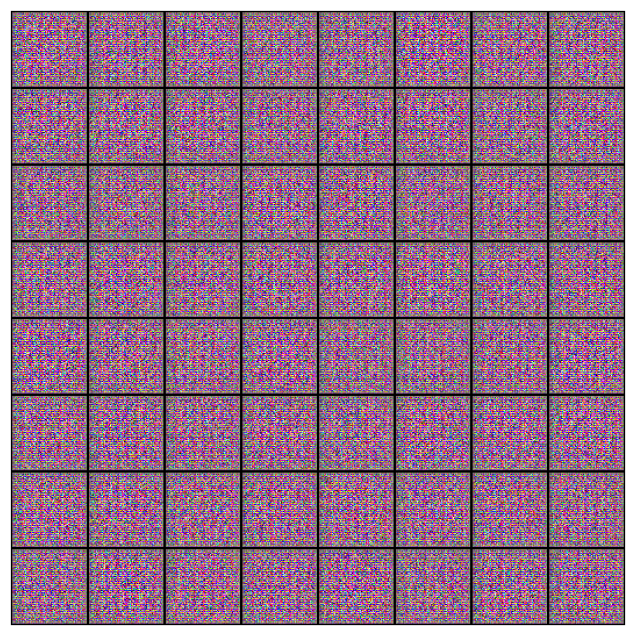

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))



In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):

            optimizer["discriminator"].zero_grad()

            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            optimizer["generator"].zero_grad(

            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=True)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 80

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/80], loss_g: 4.7310, loss_d: 0.3142, real_score: 0.8778, fake_score: 0.1185


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [2/80], loss_g: 4.8733, loss_d: 0.5621, real_score: 0.8186, fake_score: 0.1864


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [3/80], loss_g: 5.0072, loss_d: 0.3453, real_score: 0.8766, fake_score: 0.1442


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [4/80], loss_g: 5.3734, loss_d: 0.4848, real_score: 0.8408, fake_score: 0.1644


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [5/80], loss_g: 5.3850, loss_d: 0.7513, real_score: 0.7917, fake_score: 0.1865


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [6/80], loss_g: 4.6824, loss_d: 0.5579, real_score: 0.8103, fake_score: 0.2081


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [7/80], loss_g: 4.6227, loss_d: 0.4222, real_score: 0.8352, fake_score: 0.1611


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [8/80], loss_g: 4.7906, loss_d: 0.4584, real_score: 0.8325, fake_score: 0.1631


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [9/80], loss_g: 5.2094, loss_d: 0.5232, real_score: 0.8321, fake_score: 0.1817


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [10/80], loss_g: 4.2375, loss_d: 0.6958, real_score: 0.7759, fake_score: 0.2056


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [11/80], loss_g: 4.2343, loss_d: 0.4261, real_score: 0.8335, fake_score: 0.1610


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [12/80], loss_g: 4.6675, loss_d: 0.5067, real_score: 0.8189, fake_score: 0.1669


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [13/80], loss_g: 4.3202, loss_d: 0.4411, real_score: 0.8330, fake_score: 0.1720


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [14/80], loss_g: 4.8121, loss_d: 0.5316, real_score: 0.8111, fake_score: 0.1827


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [15/80], loss_g: 4.3497, loss_d: 0.5470, real_score: 0.8061, fake_score: 0.1872


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [16/80], loss_g: 4.5863, loss_d: 0.3771, real_score: 0.8583, fake_score: 0.1594


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [17/80], loss_g: 4.7007, loss_d: 0.5417, real_score: 0.8128, fake_score: 0.1786


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [18/80], loss_g: 4.7905, loss_d: 0.6693, real_score: 0.7867, fake_score: 0.2111


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [19/80], loss_g: 4.6687, loss_d: 0.4975, real_score: 0.8190, fake_score: 0.1790


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [20/80], loss_g: 4.6110, loss_d: 0.3797, real_score: 0.8476, fake_score: 0.1482


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [21/80], loss_g: 5.1085, loss_d: 0.6966, real_score: 0.8002, fake_score: 0.2052


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [22/80], loss_g: 4.1629, loss_d: 0.6687, real_score: 0.7747, fake_score: 0.2073


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [23/80], loss_g: 4.2404, loss_d: 0.4167, real_score: 0.8335, fake_score: 0.1641


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [24/80], loss_g: 4.7743, loss_d: 0.5600, real_score: 0.8014, fake_score: 0.1819


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [25/80], loss_g: 4.4035, loss_d: 0.4083, real_score: 0.8459, fake_score: 0.1637


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [26/80], loss_g: 4.7529, loss_d: 0.4486, real_score: 0.8326, fake_score: 0.1679


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [27/80], loss_g: 4.1301, loss_d: 0.3282, real_score: 0.8661, fake_score: 0.1371


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [28/80], loss_g: 4.7430, loss_d: 0.6764, real_score: 0.7897, fake_score: 0.1928


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [29/80], loss_g: 5.0562, loss_d: 0.4815, real_score: 0.8227, fake_score: 0.1686


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [30/80], loss_g: 5.2614, loss_d: 0.6468, real_score: 0.8075, fake_score: 0.2072


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [31/80], loss_g: 4.2965, loss_d: 0.4118, real_score: 0.8370, fake_score: 0.1648


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [32/80], loss_g: 4.2221, loss_d: 0.3418, real_score: 0.8562, fake_score: 0.1340


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [33/80], loss_g: 4.4034, loss_d: 0.3029, real_score: 0.8707, fake_score: 0.1242


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [34/80], loss_g: 4.1802, loss_d: 0.9408, real_score: 0.7555, fake_score: 0.2512


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [35/80], loss_g: 4.4276, loss_d: 0.9197, real_score: 0.7112, fake_score: 0.2570


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [36/80], loss_g: 4.4263, loss_d: 0.4715, real_score: 0.8355, fake_score: 0.1850


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [37/80], loss_g: 4.1573, loss_d: 0.3541, real_score: 0.8511, fake_score: 0.1450


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [38/80], loss_g: 4.0515, loss_d: 0.2800, real_score: 0.8816, fake_score: 0.1211


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [39/80], loss_g: 4.5468, loss_d: 0.2961, real_score: 0.8788, fake_score: 0.1265


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [40/80], loss_g: 5.0254, loss_d: 0.6341, real_score: 0.7976, fake_score: 0.1894


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [41/80], loss_g: 4.4493, loss_d: 0.4093, real_score: 0.8392, fake_score: 0.1601


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [42/80], loss_g: 4.7213, loss_d: 0.4053, real_score: 0.8458, fake_score: 0.1544


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [43/80], loss_g: 4.7420, loss_d: 0.4647, real_score: 0.8269, fake_score: 0.1591


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [44/80], loss_g: 4.3806, loss_d: 0.3010, real_score: 0.8735, fake_score: 0.1230


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [45/80], loss_g: 4.3895, loss_d: 0.3231, real_score: 0.8722, fake_score: 0.1319


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [46/80], loss_g: 4.4378, loss_d: 0.2636, real_score: 0.8870, fake_score: 0.1099


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [47/80], loss_g: 4.5892, loss_d: 0.2330, real_score: 0.9030, fake_score: 0.1057


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [48/80], loss_g: 5.8284, loss_d: 1.0315, real_score: 0.7439, fake_score: 0.2428


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [49/80], loss_g: 4.5409, loss_d: 0.6286, real_score: 0.7987, fake_score: 0.2099


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [50/80], loss_g: 4.1896, loss_d: 0.3317, real_score: 0.8610, fake_score: 0.1342


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [51/80], loss_g: 3.9780, loss_d: 0.2773, real_score: 0.8778, fake_score: 0.1190


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [52/80], loss_g: 3.9577, loss_d: 0.2384, real_score: 0.8912, fake_score: 0.1016


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [53/80], loss_g: 5.3355, loss_d: 0.8601, real_score: 0.7553, fake_score: 0.2368


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [54/80], loss_g: 4.2312, loss_d: 0.4714, real_score: 0.8267, fake_score: 0.1743


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [55/80], loss_g: 4.6233, loss_d: 0.3561, real_score: 0.8653, fake_score: 0.1433


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [56/80], loss_g: 4.2481, loss_d: 0.2668, real_score: 0.8830, fake_score: 0.1127


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [57/80], loss_g: 4.6259, loss_d: 0.2906, real_score: 0.8810, fake_score: 0.1196


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [58/80], loss_g: 4.5584, loss_d: 0.3299, real_score: 0.8703, fake_score: 0.1259


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [59/80], loss_g: 4.1813, loss_d: 0.3030, real_score: 0.8737, fake_score: 0.1204


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [60/80], loss_g: 4.6368, loss_d: 0.3574, real_score: 0.8604, fake_score: 0.1316


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [61/80], loss_g: 4.3643, loss_d: 0.2707, real_score: 0.8865, fake_score: 0.1132


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [62/80], loss_g: 4.7307, loss_d: 0.3512, real_score: 0.8666, fake_score: 0.1362


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [63/80], loss_g: 4.2525, loss_d: 0.2446, real_score: 0.8941, fake_score: 0.1068


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [64/80], loss_g: 4.5764, loss_d: 0.4436, real_score: 0.8350, fake_score: 0.1309


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [65/80], loss_g: 4.9830, loss_d: 1.2174, real_score: 0.7554, fake_score: 0.2764


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [66/80], loss_g: 4.6677, loss_d: 0.7098, real_score: 0.7767, fake_score: 0.2071


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [67/80], loss_g: 4.5931, loss_d: 0.5271, real_score: 0.8285, fake_score: 0.1872


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [68/80], loss_g: 4.0392, loss_d: 0.2971, real_score: 0.8739, fake_score: 0.1234


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [69/80], loss_g: 3.9624, loss_d: 0.2850, real_score: 0.8815, fake_score: 0.1250


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [70/80], loss_g: 4.1231, loss_d: 0.2602, real_score: 0.8831, fake_score: 0.1021


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [71/80], loss_g: 4.0308, loss_d: 0.2184, real_score: 0.9001, fake_score: 0.0934


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [72/80], loss_g: 3.9355, loss_d: 0.2113, real_score: 0.9061, fake_score: 0.0955


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [73/80], loss_g: 4.3203, loss_d: 0.2293, real_score: 0.9014, fake_score: 0.0977


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [74/80], loss_g: 4.1325, loss_d: 0.2220, real_score: 0.9030, fake_score: 0.0960


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [75/80], loss_g: 4.6394, loss_d: 1.2086, real_score: 0.7273, fake_score: 0.2443


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [76/80], loss_g: 4.5397, loss_d: 0.6264, real_score: 0.8041, fake_score: 0.2232


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [77/80], loss_g: 4.5927, loss_d: 0.3754, real_score: 0.8472, fake_score: 0.1445


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [78/80], loss_g: 5.1471, loss_d: 0.7333, real_score: 0.8065, fake_score: 0.2130


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [79/80], loss_g: 4.1988, loss_d: 0.3793, real_score: 0.8484, fake_score: 0.1380


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [80/80], loss_g: 3.8887, loss_d: 0.2693, real_score: 0.8819, fake_score: 0.1128
Saving generated-images-0080.png


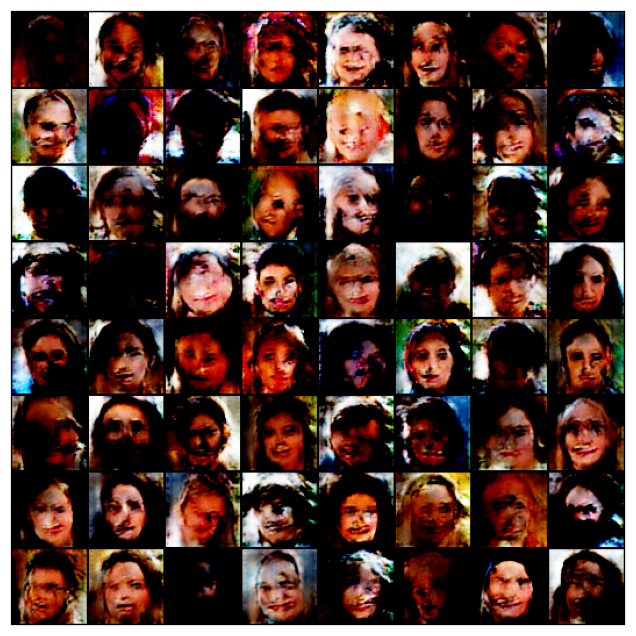

In [ ]:
history = fit(model, criterion, epochs, lr)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img) = generated_img[:, :, [2, 1, 0]]

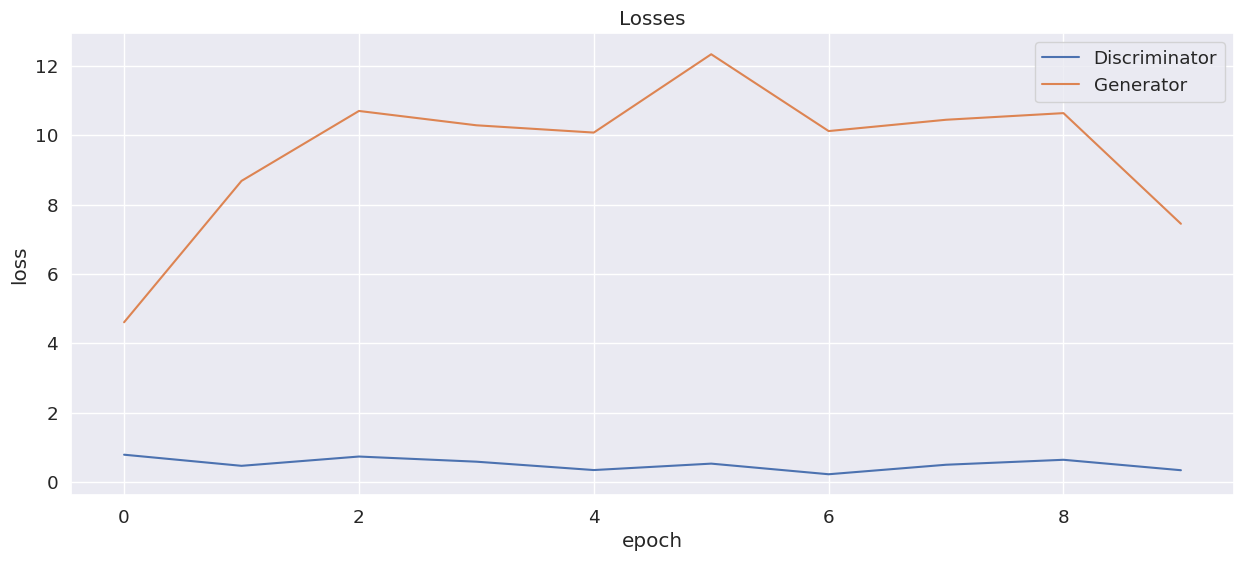

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

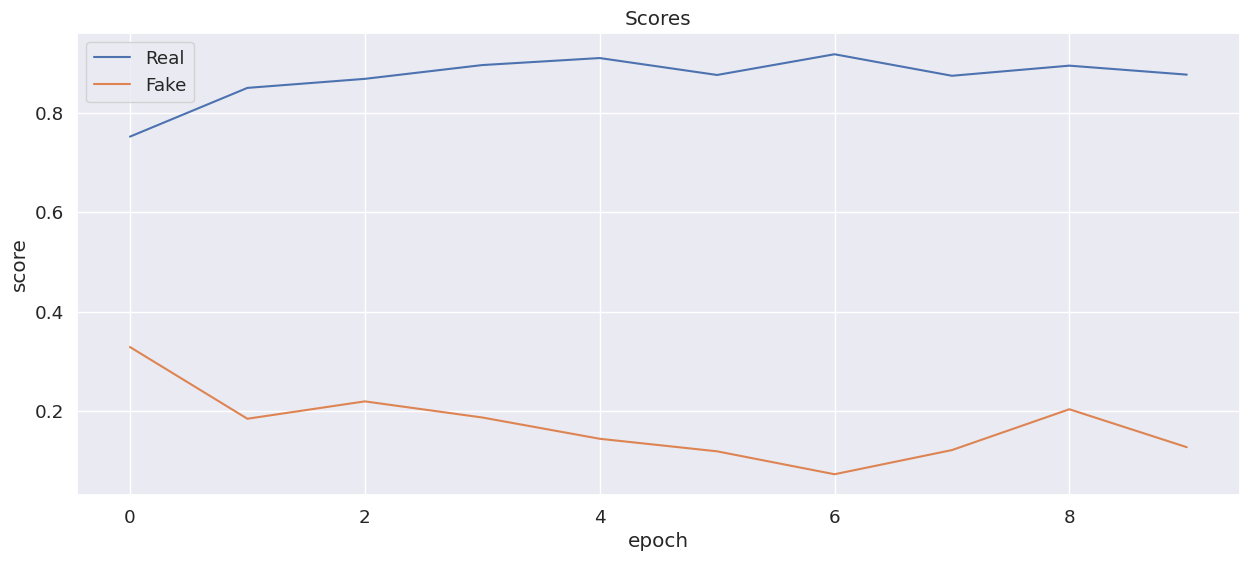

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');